# Sentiment analysis: Twitter

## Key terms

- **Tokenization**: Splitting text into individual units (tokens), typically words. For example, "I love this!" becomes `["i", "love", "this"]`. This is the first step in converting text to a format neural networks can process.

- **Embedding**: A dense vector representation of a token. Instead of one-hot encoding (sparse, high-dimensional), embeddings map each word to a fixed-size vector (e.g., 100 dimensions) where similar words have similar vectors. We use pretrained GloVe embeddings trained on Twitter data.

- **LSTM/GRU**: Variants of RNNs designed to handle long sequences better than SimpleRNN. They use "gates" to control information flow, solving the vanishing gradient problem. **GRU** (Gated Recurrent Unit) has 2 gates and is simpler; **LSTM** (Long Short-Term Memory) has 3 gates and more parameters. Both work well in practice — we use GRU here for efficiency.

## How the GRU processes a sequence

Given input sequence `["i", "love", "this]`, the GRU predicts sentiment:

```text

                   ┌────────────◀───────────┐ 'h₁', then 'h₂'
                   ▼                        │
                ╔══════════════════════════════╗
                ║  │           GRU          ▲  ║
                ║  │                        │  ║
  'I' then,     ║  ├──▶Reset───▶candidate──▶│  ║         ╔═══════╗ 
'love', then ══▶║  │   gate      hidden     │  ╠══'h₃'══▶║ Dense ╠══▶ Sentiment
   'this'       ║  │              state     │  ║         ╚═══════╝
                ║  │                        │  ║
                ║  └─────▶Update gate───────┘  ║
                ╚══════════════════════════════╝

```

- **Reset gate**: Controls how much the prior hidden state influences the new candidate hidden state. Gates are **dynamic weights** (0-1) — one per hidden unit — computed fresh for each input. Depend on **both** the previous hidden state AND the current input.
- **Update gate**: Controls how much prior hidden state vs new candidate hidden state goes into the new hidden state. Also computed from previous hidden state + current input, just with different learned weights.
- **Bidirectional recurrent layers**: Processes a sequence in both directions (forward and backward) and combines the results. This allows the model to use context from both before AND after each word, improving understanding.

## External tools & resources

- **Stopwords**: Common words (e.g., "the", "is", "at") filtered out during preprocessing to reduce noise and focus on meaningful content.
  - *This project*: [NLTK Stopwords](https://www.nltk.org/nltk_data/) — curated lists for 20+ languages
  - *Alternatives*: [spaCy stopwords](https://spacy.io/usage/rule-based-matching#vocab-stopwords), [scikit-learn ENGLISH_STOP_WORDS](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.html)

- **Tokenizers**: Tools that split text into tokens. Different tokenizers handle edge cases differently — social media text requires special handling for emoticons, hashtags, and informal spelling.
  - *This project*: [NLTK TweetTokenizer](https://www.nltk.org/api/nltk.tokenize.casual.html#nltk.tokenize.casual.TweetTokenizer) — handles emoticons, hashtags, mentions, and normalizes repeated characters (e.g., "sooooo" → "sooo")
  - *Alternatives*: [spaCy Tokenizer](https://spacy.io/usage/linguistic-features#tokenization), [Hugging Face Tokenizers](https://huggingface.co/docs/tokenizers/), [NLTK word_tokenize](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html)

- **Word Embeddings**: Pretrained vector representations that capture semantic relationships between words. Using pretrained embeddings transfers knowledge from large corpora to your model.
  - *This project*: [GloVe Twitter embeddings](https://nlp.stanford.edu/projects/glove/) — trained on 27B Twitter tokens, 100 dimensions
  - *Alternatives*: [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html), [FastText](https://fasttext.cc/docs/en/english-vectors.html), [Hugging Face sentence-transformers](https://huggingface.co/sentence-transformers)

## Notebook setup

### Imports

In [ ]:
import os
import re
import zipfile
import urllib.request
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

### Configuration

In [ ]:
# Configure GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth on ALL GPUs (required when multiple GPUs present)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'Using {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}')
        
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using CPU')

# Download NLTK resources
nltk.download('stopwords', quiet=True)

# Set up stop words and tokenizer
stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# GloVe download settings
glove_dir = '../data'
glove_url = 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'
glove_file = os.path.join(glove_dir, 'glove.twitter.27B.100d.txt')
glove_zip = os.path.join(glove_dir, 'glove.twitter.27B.zip')

## 1. Data preparation

### 1.1. Load

In [3]:
df = pd.read_parquet('../data/twitter-2016.parquet')
df.head()

,id,name,score,text
0,638060586258038784,michael jackson,0,05 Beat it - Michael Jackson - Thriller (25th ...
1,638061181823922176,michael jackson,1,Jay Z joins Instagram with nostalgic tribute t...
2,638083821364244480,michael jackson,0,Michael Jackson: Bad 25th Anniversary Edition ...
3,638091450132078593,michael jackson,1,I liked a @YouTube video http://t.co/AaR3pjp2P...
4,638125563790557184,michael jackson,1,18th anniv of Princess Diana's death. I still ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30467 entries, 0 to 30466
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30467 non-null  int64 
 1   name    30467 non-null  object
 2   score   30467 non-null  int64 
 3   text    30467 non-null  object
dtypes: int64(2), object(2)
memory usage: 952.2+ KB


### 1.2. Clean

In [5]:
# Clean data - drop rows with missing scores
df_clean = df.dropna(subset=['score']).copy()
df_clean['score'] = df_clean['score'].astype(int)

# Shift scores to 0-based index: [-2,-1,0,1,2] -> [0,1,2,3,4]
score_min = df_clean['score'].min()
df_clean['score_shifted'] = df_clean['score'] - score_min

print(f'Cleaned dataset: {len(df_clean):,} rows ({len(df) - len(df_clean):,} dropped)')
print(f'Score distribution: {df_clean["score_shifted"].value_counts().sort_index().to_dict()}')

Cleaned dataset: 30,467 rows (0 dropped)
Score distribution: {0: 299, 1: 3392, 2: 12953, 3: 12812, 4: 1011}


### 1.3. Tokenize

In [6]:
# Clean and tokenize text using NLTK's TweetTokenizer
def clean_text(text):
    '''Clean and tokenize tweet text using TweetTokenizer.'''

    if not isinstance(text, str):
        return []

    # Remove URLs before tokenizing
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # TweetTokenizer handles: lowercase, @mentions, repeated chars (e.g., sooooo -> sooo)
    tokens = tweet_tokenizer.tokenize(text)

    # Remove '#' symbols from hashtags (keep the word)
    tokens = [t.lstrip('#') for t in tokens]

    # Remove stopwords and single characters
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    return tokens

# Apply tokenization
df_clean['tokens'] = df_clean['text'].apply(clean_text)
df_clean[['text', 'tokens', 'score']].head()

,text,tokens,score
0,05 Beat it - Michael Jackson - Thriller (25th ...,"[05, beat, michael, jackson, thriller, 25th, a...",0
1,Jay Z joins Instagram with nostalgic tribute t...,"[jay, joins, instagram, nostalgic, tribute, mi...",1
2,Michael Jackson: Bad 25th Anniversary Edition ...,"[michael, jackson, bad, 25th, anniversary, edi...",0
3,I liked a @YouTube video http://t.co/AaR3pjp2P...,"[liked, video, one, direction, singing, man, m...",1
4,18th anniv of Princess Diana's death. I still ...,"[18th, anniv, princess, diana's, death, still,...",1


### 1.4. Build vocabulary

In [7]:
# Build vocabulary
def build_vocab(token_lists, min_freq=2):
    '''Build vocabulary from token lists.'''

    counter = Counter()

    for tokens in token_lists:
        counter.update(tokens)
    
    # Filter by minimum frequency and create vocab
    vocab = {'<PAD>': 0, '<UNK>': 1}

    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

vocab = build_vocab(df_clean['tokens'])
print(f'Vocabulary size: {len(vocab)}\n')

print(f'Example vocab entries:')
for key, _ in list(vocab.items())[-15:]:
    print(f' {key}')

Vocabulary size: 14965

Example vocab entries:
 sardinia
 #lambily
 elha's
 ballon
 d'or
 #argentina
 #bolivia
 arg
 bafana
 iniesta
 kluivert
 mascherano
 gunny
 apoel
 bowles


### 1.5. Convert to indices

In [8]:
def tokens_to_indices(tokens_list, vocab, max_len=50):
    '''Convert token lists to padded index sequences.'''

    sequences = []

    for tokens in tokens_list:
        indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        sequences.append(indices)

    # Pad sequences to max_len
    return pad_sequences(sequences, maxlen=max_len, padding='post', value=vocab['<PAD>'])

# Convert all data to indices
max_len = 50
X = tokens_to_indices(df_clean['tokens'].tolist(), vocab, max_len)
y = df_clean['score_shifted'].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (30467, 50)
y shape: (30467,)


### 1.6. Train/test split

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=315,
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Score distribution (train): {Counter(y_train)}')

X_train shape: (24373, 50)
X_test shape: (6094, 50)
Score distribution (train): Counter({2: 10362, 3: 10249, 1: 2714, 4: 809, 0: 239})


## 2. Prepare GloVe embeddings

GloVe (Global Vectors) provides pretrained word embeddings trained on large text corpora. Using these gives our model a head start - words already have meaningful representations instead of random vectors.

### 2.1. Download embeddings

In [ ]:
if not os.path.exists(glove_file):

    print('Downloading GloVe embeddings...')
    urllib.request.urlretrieve(glove_url, glove_zip)

    print('Extracting...')
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extract('glove.twitter.27B.100d.txt', glove_dir)

    os.remove(glove_zip)
    print('Done!')

else:
    print(f'GloVe file already exists: {glove_file}')

GloVe file already exists: ../data/glove.twitter.27B.100d.txt


### 2.2. Load embeddings into dictionary

In [11]:
glove_vectors = {}

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:

        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_vectors[word] = vector

print(f'Loaded {len(glove_vectors):,} word vectors')
print(f'Embedding dimension: {len(next(iter(glove_vectors.values())))}')

Loaded 1,193,514 word vectors
Embedding dimension: 100


### 2.3. Create embedding look-up table for our vocabulary

In [12]:
embedding_dim = 100  # GloVe Twitter uses 100d
vocab_size = len(vocab)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
words_found = 0

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
        words_found += 1

    else:
        # Random initialization for words not in GloVe
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

coverage = words_found / vocab_size
print(f'Vocabulary coverage: {words_found:,} / {vocab_size:,} ({coverage:.1%})')
print(f'Embedding matrix shape: {embedding_matrix.shape}')

Vocabulary coverage: 12,976 / 14,965 (86.7%)
Embedding matrix shape: (14965, 100)


## 3. Bidirectional GRU model

### 3.1. Build model

In [13]:
# Model hyperparameters
hidden_dim = 64
output_dim = len(set(y_train))
dropout = 0.3            # Spatial dropout rate
l2_reg = 0.01            # L2 regularization strength
learning_rate = 0.0001   # Lower LR for fine-tuning embeddings

# Build Bidirectional GRU model with pretrained GloVe embeddings
model = Sequential([
    Embedding(
        vocab_size, 
        embedding_dim,
        weights=[embedding_matrix],
        trainable=True  # Fine-tune embeddings with lower learning rate
    ),
    SpatialDropout1D(dropout),
    Bidirectional(GRU(
        hidden_dim,
        
        return_sequences=True
    )),
    Bidirectional(GRU(
        hidden_dim // 2, # Second layer, smaller

    )),
    Dropout(dropout),
    Dense(output_dim, activation='softmax', kernel_regularizer=l2(l2_reg))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1496500   
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, None, 128)         63744     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

### 3.2. Define training callbacks

In [14]:
callbacks = [
    ModelCheckpoint(
        '../models/rnn_classifier.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=0
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    ),
    TensorBoard(
        log_dir='../logs/rnn_classifier',
        histogram_freq=1,
        write_graph=True
    )
]

### 3.3. Calculate class weights

In [15]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

Class weights: {0: 20.39581589958159, 1: 1.7960943257184967, 2: 0.47043041883806214, 3: 0.47561713337886624, 4: 6.025463535228678}


### 3.4. Train the model

In [16]:
# Training with class weighting and early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1771296590.224420 1366506 service.cc:145] XLA service 0x79b9f807de10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771296590.224509 1366506 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1771296590.337781 1366506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 [==============================] - 89s 116ms/step - loss: 1.7084 - accuracy: 0.1928 - val_loss: 1.6225 - val_accuracy: 0.2402
Epoch 2/30
381/381 [==============================] - 30s 80ms/step - loss: 1.6045 - accuracy: 0.2277 - val_loss: 1.5567 - val_accuracy: 0.2348
Epoch 3/30
381/381 [==============================] - 30s 77ms/step - loss: 1.5228 - accuracy: 0.2474 - val_loss: 1.5926 - val_accuracy: 0.1785
Epoch 4/30
381/381 [==============================] - 29s 75ms/step - loss: 1.4579 - accuracy: 0.2618 - val_loss: 1.5214 - val_accuracy: 0.2333
Epoch 5/30
381/381 [==============================] - 29s 76ms/step - loss: 1.4025 - accuracy: 0.2843 - val_loss: 1.4717 - val_accuracy: 0.2875
Epoch 6/30
381/381 [==============================] - 28s 74ms/step - loss: 1.3621 - accuracy: 0.3008 - val_loss: 1.4189 - val_accuracy: 0.3412
Epoch 7/30
381/381 [==============================] - 28s 74ms/step - loss: 1.3260 - accuracy: 0.3172 - val_loss: 1.3480 - val_accuracy: 0.3815
Ep

### 4.5. Learning curves

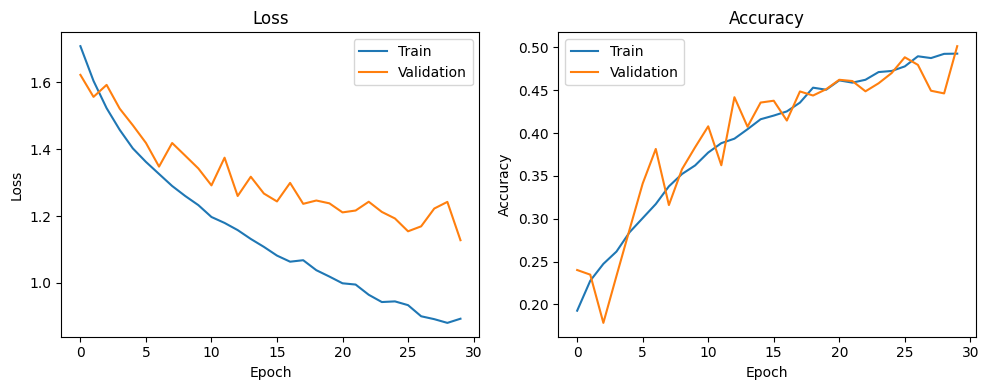

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Evaluation

### 4.1. Make test set predictions

In [18]:
# Load best model and get predictions
model = tf.keras.models.load_model('../models/rnn_classifier.keras')

# Get predicted probabilities and classes
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)

# Class labels
class_names = ['-2', '-1', '0', '1', '2']
n_classes = len(class_names)

print(f'Test samples: {len(y_test)}')
print(f'Prediction distribution:')
print(f'  Actual:    {Counter(y_test)}')
print(f'  Predicted: {Counter(y_pred)}')

191/191 [==============================] - 7s 16ms/step
Test samples: 6094
Prediction distribution:
  Actual:    Counter({2: 2591, 3: 2563, 1: 678, 4: 202, 0: 60})
  Predicted: Counter({2: 2055, 3: 1970, 1: 1185, 4: 736, 0: 148})


### 4.2. Per-class accuracy

In [19]:
# Per-class accuracy table
per_class_stats = []

for i, class_name in enumerate(class_names):
    mask = y_test == i
    n_samples = mask.sum()
    n_correct = (y_pred[mask] == i).sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    
    per_class_stats.append({
        'Class': class_name,
        'Samples': n_samples,
        'Correct': n_correct,
        'Accuracy': f'{accuracy:.1%}'
    })

# Add overall accuracy
overall_acc = (y_pred == y_test).mean()
per_class_stats.append({
    'Class': 'Overall',
    'Samples': len(y_test),
    'Correct': (y_pred == y_test).sum(),
    'Accuracy': f'{overall_acc:.1%}'
})

accuracy_df = pd.DataFrame(per_class_stats)
accuracy_df

,Class,Samples,Correct,Accuracy
0,-2,60,23,38.3%
1,-1,678,388,57.2%
2,0,2591,1285,49.6%
3,1,2563,1234,48.1%
4,2,202,126,62.4%
5,Overall,6094,3056,50.1%


### 4.3. Confusion matrix

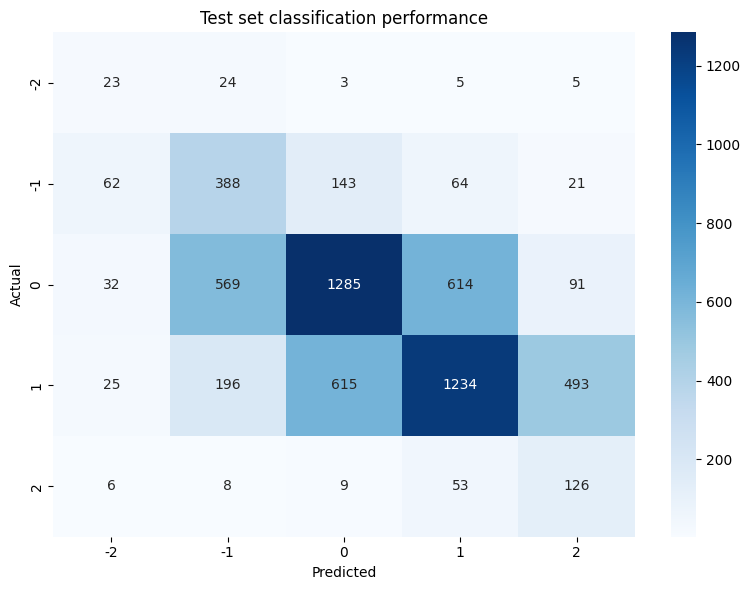

In [20]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Test set classification performance')

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, 
    annot=True, fmt='d', cmap='Blues', 
    xticklabels=class_names, yticklabels=class_names, ax=ax
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 4.4. Predicted probability distributions by class

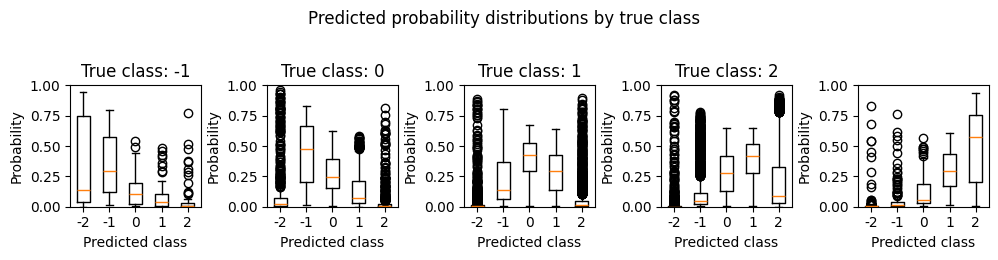

In [21]:
# Predicted probability distributions for each true class
fig, axes = plt.subplots(1, n_classes, figsize=(10, 2.5))

plt.suptitle('Predicted probability distributions by true class', y=1.02)

for i, class_name in enumerate(class_names):

    ax.set_title(f'True class: {class_name}')

    # Get predictions for samples of this true class
    mask = y_test == i
    probs_for_class = y_prob[mask]
    
    # Plot distribution of predicted probabilities for each predicted class
    ax = axes[i]
    ax.boxplot([probs_for_class[:, j] for j in range(n_classes)], tick_labels=class_names)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### 4.5. Evaluation curves

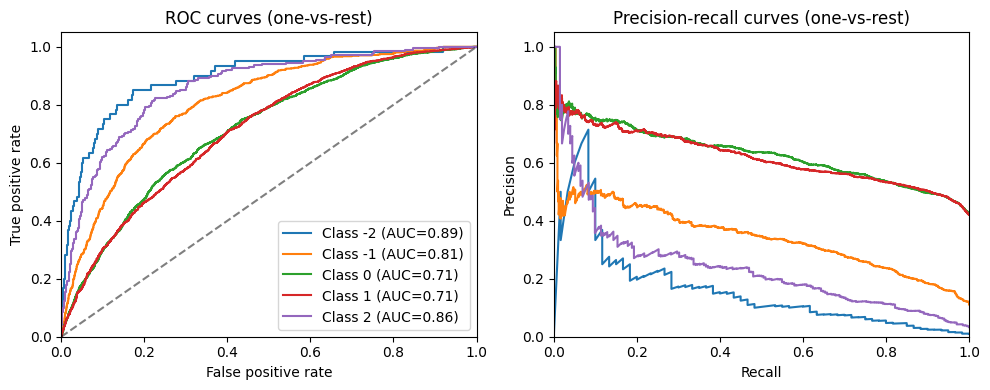

In [22]:
# Binarize labels for multiclass ROC/PR
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC and PR curves for each class
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ROC curves
ax_roc = axes[0]
ax_roc.set_title('ROC curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f'Class {class_name} (AUC={roc_auc:.2f})')

ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax_roc.set_xlabel('False positive rate')
ax_roc.set_ylabel('True positive rate')
ax_roc.legend(loc='lower right')
ax_roc.set_xlim([0, 1])
ax_roc.set_ylim([0, 1.05])

# PR curves
ax_pr = axes[1]
ax_pr.set_title('Precision-recall curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    ax_pr.plot(recall, precision, label=f'Class {class_name} (AUC={pr_auc:.2f})')

ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_xlim([0, 1])
ax_pr.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()